In [ ]:
!python -m nltk.downloader stopwords wordnet punkt averaged_perceptron_tagger

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
!pip install -q contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.9 MB/s eta 0:00:00


In [69]:
import os
import re
import pprint
import random
import string
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from contractions import contractions_dict

seed = random.seed(42)

In [70]:
drive.mount('/content/drive')
! cd drive
os.chdir("/content/drive/MyDrive/Data 266 Project")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 1: cd: drive: No such file or directory
'=0.20.1'					       exploration.ipynb
 1_extract_sample_data.ipynb			       Finetuning_bart.ipynb
 2_eda.ipynb					       Finetuning_t5.ipynb
 3_baseline_exploration.ipynb			       initial_baseline.ipynb
'Combining Extractive and Abstractive Summarization'   models
'Copy of Finetuning_bart.ipynb'			       prediction_eval.ipynb
 df_baseline.csv				      'Project 266 Notes.gdoc'
 df_test.csv					      'Project Milestone.gdoc'
 df_train.csv					      'Project Proposal 266.gdoc'
 df_valid.csv					       sample_data.csv


In [71]:
df = pd.read_csv("sample_data.csv")

In [ ]:
# Check for rows with null values
# print(df.isnull().values.any())
# print(df.shape)

# False
# (36000, 4)

In [72]:
df.head()

,subreddit,id,content,summary
0,AskReddit,cg6bla3,My family used to take a summer vacation every...,girlfriend gave me a blowjob in the backseat w...
1,AskReddit,cdysm9o,I was 3 and I lived on the oceanside in New Je...,"crab trapping at 3 y/o, one charged at me, boo..."
2,AskReddit,cq23cxz,"Late to the show, but here we go. This is goin...",Why would you go to\n r/askreddit and not read...
3,AskReddit,ce2dbzz,The reason that many people die from drug over...,The brain is amazing. Don't ever believe someo...
4,AskReddit,ce5sxwr,I'm doing something I enjoy (CAD drawing). \nW...,"I'm doing just fine, and I don't regret a sing..."


In [73]:
for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


# Data Preparation

## Expand contractions

In [74]:
def expand_contractions(text, contraction_map=contractions_dict):

  contractions_keys = '|'.join(contraction_map.keys())
  contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

  def expand_match(contraction):
      match = contraction.group(0)
      expanded_contraction = contraction_map.get(match)
      if not expand_contractions:
          print(match)
          return match
      return expanded_contraction

  expanded_text = contractions_pattern.sub(expand_match, text)
  expanded_text = re.sub("'", "", expanded_text)
  return expanded_text

In [75]:
expand_contractions("I'd like to see if I'll understand Whatcha doing")

'I would like to see if I will understand What are you doing'

In [76]:
df.content = df.content.apply(expand_contractions)
df.summary = df.summary.apply(expand_contractions)
df.head()

,subreddit,id,content,summary
0,AskReddit,cg6bla3,My family used to take a summer vacation every...,girlfriend gave me a blowjob in the backseat w...
1,AskReddit,cdysm9o,I was 3 and I lived on the oceanside in New Je...,"crab trapping at 3 y/o, one charged at me, boo..."
2,AskReddit,cq23cxz,"Late to the show, but here we go. This is goin...",Why would you go to\n r/askreddit and not read...
3,AskReddit,ce2dbzz,The reason that many people die from drug over...,The brain is amazing. Dont ever believe someon...
4,AskReddit,ce5sxwr,I am doing something I enjoy (CAD drawing). \n...,"I am doing just fine, and I do not regret a si..."


## Remove stop words

In [77]:
def remove_stopwords(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

In [78]:
df.content = df.content.apply(remove_stopwords)
df.summary = df.summary.apply(remove_stopwords)
df.head()

,subreddit,id,content,summary
0,AskReddit,cg6bla3,My family used take summer vacation every year...,girlfriend gave blowjob backseat mom driving.
1,AskReddit,cdysm9o,I 3 I lived oceanside New Jersey. My dad would...,"crab trapping 3 y/o, one charged me, booked ho..."
2,AskReddit,cq23cxz,"Late show, go. This going long, buckle up. My ...",Why would go r/askreddit read answers? Come on.
3,AskReddit,ce2dbzz,The reason many people die drug overdoses hote...,The brain amazing. Dont ever believe someone t...
4,AskReddit,ce5sxwr,I something I enjoy (CAD drawing). When I quit...,"I fine, I regret single second."


## Remove numbers and puncuation

In [79]:
def remove_num_punc(text):
  # Remove numbers from the text
  text_without_numbers = re.sub('[0-9]+', '', text)

  words = text_without_numbers.split()

  # Remove punctuation from each word and rejoin the words
  clean_words = [''.join([char for char in word if char not in string.punctuation]) for word in words]
  return ' '.join(clean_words)

In [80]:
df.content = df.content.apply(remove_num_punc)
df.summary = df.summary.apply(remove_num_punc)
df.head()

,subreddit,id,content,summary
0,AskReddit,cg6bla3,My family used take summer vacation every year...,girlfriend gave blowjob backseat mom driving
1,AskReddit,cdysm9o,I I lived oceanside New Jersey My dad would pu...,crab trapping yo one charged me booked home sc...
2,AskReddit,cq23cxz,Late show go This going long buckle up My youn...,Why would go raskreddit read answers Come on
3,AskReddit,ce2dbzz,The reason many people die drug overdoses hote...,The brain amazing Dont ever believe someone te...
4,AskReddit,ce5sxwr,I something I enjoy CAD drawing When I quit sc...,I fine I regret single second


## Word Count Distribution

In [81]:
def word_count_distribution(df):

    content_word_count = [len(i.split(' ')) for i in df['content']]
    summary_word_count = [len(i.split(' ')) for i in df['summary']]

    length_df = pd.DataFrame({'content': content_word_count, 'summary': summary_word_count})

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    length_df.hist(bins=30, ax=axes)

    # Adding Max, Mean, Min labels and setting titles for each subplot
    for ax, col in zip(axes, length_df.columns):
        max_value = length_df[col].max()
        mean_value = length_df[col].mean()
        min_value = length_df[col].min()

        ax.set_title(f'Distribution of {col.capitalize()} Word Counts')
        ax.set_xlabel('Word Count')
        ax.set_ylabel('Posts')
        ax.text(0.98, 0.98, f'Max: {max_value}\nMean: {mean_value:.2f}\nMin: {min_value}',
                horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,
                fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()


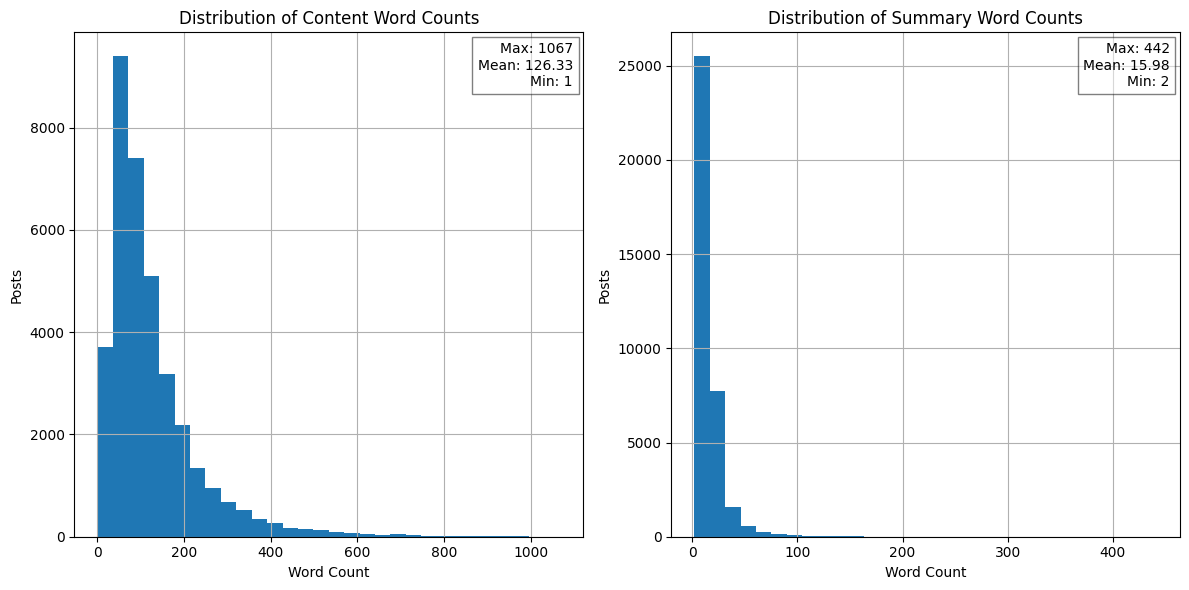

In [82]:
word_count_distribution(df)

In [83]:
def word_count_percentiles(df, column_name):
  word_count = pd.DataFrame()
  word_count['article_count'] = df[column_name].apply(lambda x: len(str(x).split()))
  for i in range(90,100):
    var = word_count['article_count'].values
    var = np.sort(var,axis=None)
    print('Word count at {} percentile: {}'.format(i,var[int(len(var)*(float(i)/100))]))
  print("100 percentile - ",var[-1])

In [84]:
word_count_percentiles(df, 'content')

Word count at 90 percentile: 249
Word count at 91 percentile: 260
Word count at 92 percentile: 275
Word count at 93 percentile: 291
Word count at 94 percentile: 310
Word count at 95 percentile: 332
Word count at 96 percentile: 358
Word count at 97 percentile: 397
Word count at 98 percentile: 461
Word count at 99 percentile: 562
100 percentile -  1067


In [85]:
word_count_percentiles(df, 'summary')

Word count at 90 percentile: 28
Word count at 91 percentile: 29
Word count at 92 percentile: 30
Word count at 93 percentile: 32
Word count at 94 percentile: 34
Word count at 95 percentile: 37
Word count at 96 percentile: 41
Word count at 97 percentile: 46
Word count at 98 percentile: 55
Word count at 99 percentile: 72
100 percentile -  440


In [ ]:
# df['content'] = df['content'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_CONTENT_LEN]))
# df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_SUMMARY_LEN]))

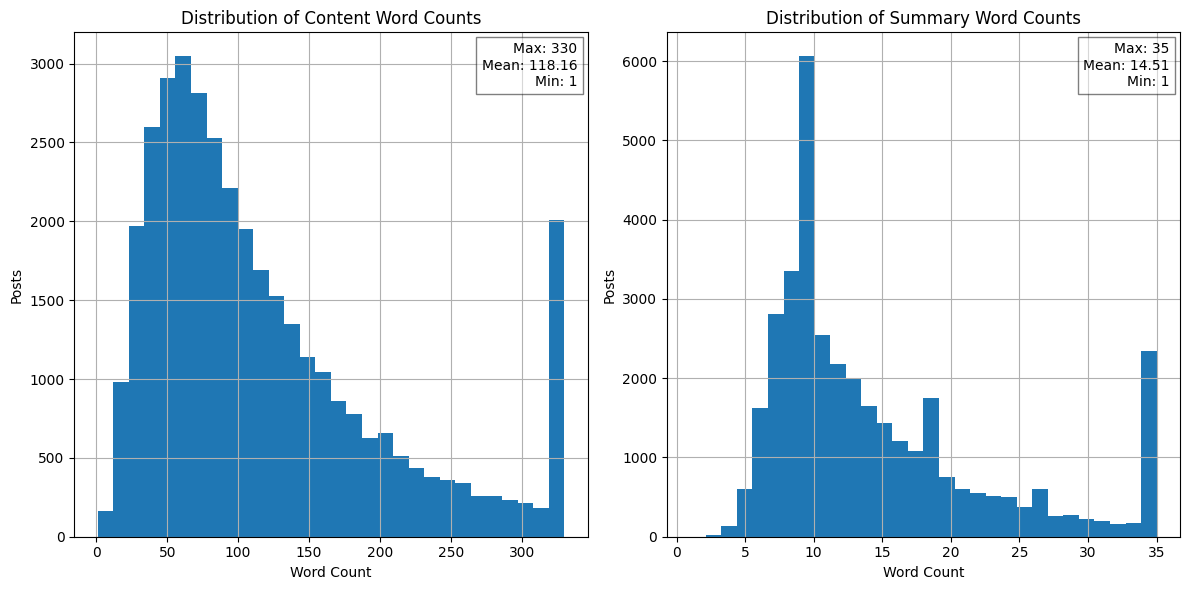

In [ ]:
# word_count_distribution(df)

In [86]:
def remove_uncommon_words(df, column_name='content', threshold=2):
    """
    Removes uncommon words from a specified column

    """
    if column_name not in df.columns:
        raise ValueError(f"Column {column_name} not found in DataFrame")

    # Tokenize and count word occurrences
    word_dict = {}
    text = df[column_name].apply(lambda x: nltk.word_tokenize(str(x)))
    for row in text:
        for word in row:
            word_dict[word] = word_dict.get(word, 0) + 1

    print("Word Count Before Uncommon Word Removal: ")
    print(len(word_dict))

    # Identify words that occur more than the threshold
    accept_words = set(word for word, count in word_dict.items() if count > threshold)

    # Remove uncommon words
    df[column_name] = text.apply(lambda tokens: " ".join(word for word in tokens if word.lower() in accept_words))

    # Count words after removal
    word_dict_after = {}
    text_after = df[column_name].apply(lambda x: nltk.word_tokenize(str(x)))
    for row in text_after:
        for word in row:
            word_dict_after[word] = word_dict_after.get(word, 0) + 1

    # Print word count after removal
    print("Word Count After Uncommon Word Removal: ")
    print(len(word_dict_after))

    return df

In [87]:
UNCOMMON_WORD_THRESHOLD = 2
df = remove_uncommon_words(df, 'content', UNCOMMON_WORD_THRESHOLD)

Word Count Before Uncommon Word Removal: 
128573
Word Count After Uncommon Word Removal: 
51918


In [89]:
df = remove_uncommon_words(df, 'summary', UNCOMMON_WORD_THRESHOLD)

Word Count Before Uncommon Word Removal: 
19814
Word Count After Uncommon Word Removal: 
19814


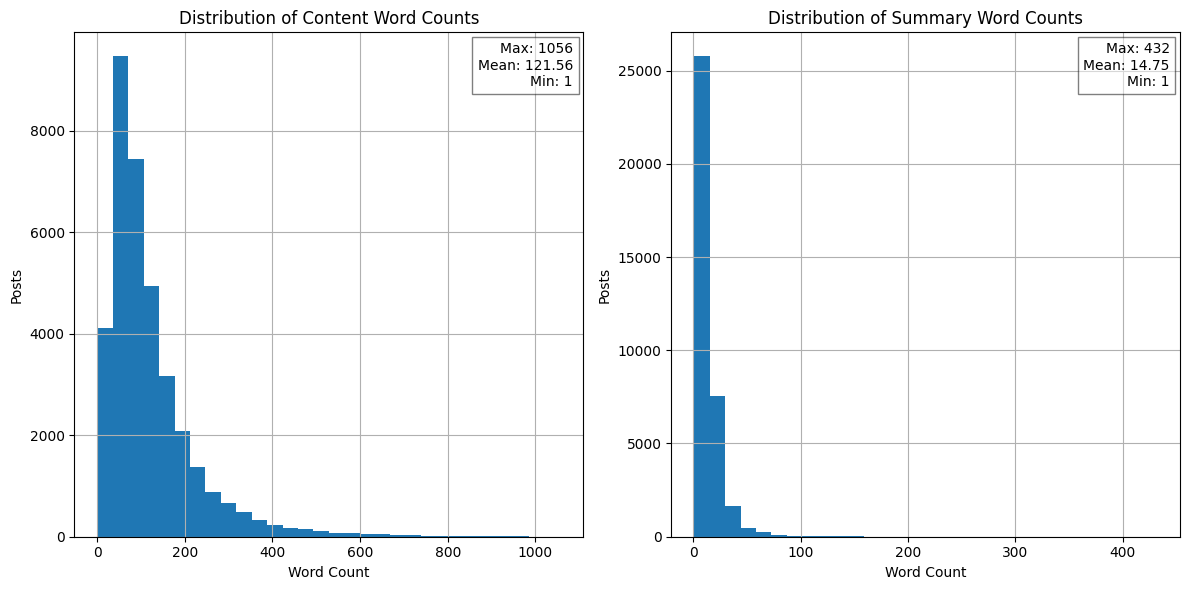

In [90]:
word_count_distribution(df)

In [91]:
# mark the beginning and end of the summary
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [92]:
!os.chdir('/content/drive/MyDrive/Data 266 Project/LSTM')

/bin/bash: -c: line 1: syntax error near unexpected token `'/content/drive/MyDrive/Data 266 Project/LSTM''
/bin/bash: -c: line 1: `os.chdir('/content/drive/MyDrive/Data 266 Project/LSTM')'


In [95]:
df.to_csv('df_clean.csv')